### Import

In [3463]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE, RandomOverSampler

#plot
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

#technical analysis
import ta
import ta.momentum
import ta.volatility

#### Ignore warnings

In [3464]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [3465]:
df = pd.read_csv("./data/nasdaq/csv/INTC.csv", sep=',')

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.index = range(len(df))

df.tail()
df.set_index('Date', inplace=True)

all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_dates) 
df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']] = df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']].interpolate(method='linear')
df['Open'] = df['Close'].shift(1)
df['High'] = df[['High', 'Open', 'Close']].max(axis=1)
df['Low'] = df[['Low', 'Open', 'Close']].min(axis=1)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

### Add technical analysis indicators

#### RSI - Relative Strength Index

In [3466]:
df['RSI7'] = ta.momentum.RSIIndicator(df['Close'], window=7).rsi()
df['RSI14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['RSI30'] = ta.momentum.RSIIndicator(df['Close'], window=30).rsi()
# df['RSI50'] = ta.momentum.RSIIndicator(df['Close'], window=50).rsi()

# df['MEAN_RSI7_5'] = df['RSI7'].rolling(window=5).mean()
# df['MEAN_RSI14_5'] = df['RSI14'].rolling(window=5).mean()
# df['MEAN_RSI30_5'] = df['RSI30'].rolling(window=5).mean()
# df['MEAN_RSI50_5'] = df['RSI50'].rolling(window=5).mean()

# df['DRSI7'] = df['RSI7'].diff()
# df['DRSI14'] = df['RSI14'].diff()
# df['DRSI30'] = df['RSI30'].diff()

#### SMA - Simple Moving Average

In [3467]:
# df['SMA5'] = ta.trend.SMAIndicator(df['Close'], window=5).sma_indicator()
# df['SMA10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()
# df['SMA20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()

#### EMA - Exponential Moving Average

In [3468]:
# df['EMA5'] = ta.trend.EMAIndicator(df['Close'], window=5).ema_indicator()
# df['EMA10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
# df['EMA20'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

### ADX - Average Directional Movement

In [3469]:
df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14).adx()

### Bollinger Bands

In [3470]:
bb = ta.volatility.BollingerBands(close=df['Close'])
df['HB'] = bb.bollinger_hband()
df['LB'] = bb.bollinger_lband()
df['MB'] = bb.bollinger_mavg()
df['%B'] = (df['Close'] - df['LB']) / (df['HB'] - df['LB'])
df['BBBandWidth'] = (df['HB'] - df['LB']) / df['MB']

In [3471]:
# #consecutive days above sma20
# df['AboveSMA20'] = (df['Close'] > df['MB']).astype(int)
# df['DASMA'] = 0
# consecutive_count = 0
# r = np.zeros(len(df), dtype=int)
# for i in range(1, len(df)):
#     if df['AboveSMA20'].iloc[i]:
#         consecutive_count += 1
#     else:
#         consecutive_count = 0
#     r[i] = consecutive_count
# df['DASMA'] = r
# df.drop(['AboveSMA20'], axis=1, inplace=True)

In [3472]:
# #consecutive days above sma20
# df['BelowSMA20'] = (df['Close'] < df['MB']).astype(int)
# df['DBSMA'] = 0
# consecutive_count = 0
# r = np.zeros(len(df), dtype=int)
# for i in range(1, len(df)):
#     if df['BelowSMA20'].iloc[i]:
#         consecutive_count += 1
#     else:
#         consecutive_count = 0
#     r[i] = consecutive_count
# df['DBSMA'] = r
# df.drop(['BelowSMA20'], axis=1, inplace=True)

### MACD

In [3473]:
# df['MACD'] = ta.trend.MACD(df['Close']).macd()
# df['MACD_signal'] = ta.trend.MACD(df['Close']).macd_signal()
# df['MACD_hist'] = ta.trend.MACD(df['Close']).macd_diff()

#### Visualize

In [3474]:
start = 6000
vdf = df[start:start+200]

fig = make_subplots(rows=7, cols=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.HB, name='Bollinger High Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.LB, name='Bollinger Low Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.MB, name='Bollinger Middle Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf['%B'], name='%B'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.BBBandWidth, name='BandWidth'), row=3, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI30, name='RSI30'), row=4, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI14, name='RSI14'), row=5, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.ADX, name='ADX'), row=6, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Volume, name='Volume'), row=7, col=1)

fig.update_layout(
    autosize=False,
    width=1500,
    height=1000,
    margin=dict(l=30,r=30,b=30,
                t=30,pad=3
                ),
    paper_bgcolor="White",
)

### Trend

In [3475]:
def calc_trend(df, n=5, threshold=0.01):
	trend = []	
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_mean = df['Close'].iloc[i+1:i+n+1].mean()
		current_close = df['Close'].iloc[i]
		if future_mean > current_close * (1 + threshold):
			trend.append('Up')
		elif future_mean < current_close * (1 - threshold):
			trend.append('Down')
		else:
			trend.append('Neutral')
	df['Trend'] = trend
	return df
df = calc_trend(df, n=15, threshold=0.02)

#### Delete invalid data

In [3476]:
df = df[100:-100]
df.index = range(len(df))

In [3477]:
df[5000:5020]

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,ADX,HB,LB,MB,%B,BBBandWidth,Trend
5000,1994-03-04,4.250000,4.250000,1.156704e+08,4.390625,4.351563,2.667245,68.935819,65.027019,60.143953,20.253307,4.400509,4.014075,4.207292,0.873340,0.091849,Neutral
5001,1994-03-05,4.302083,4.351563,1.157088e+08,4.416667,4.385417,2.687995,72.030922,66.960868,61.186316,20.781981,4.407728,4.046439,4.227083,0.938247,0.085470,Neutral
5002,1994-03-06,4.338542,4.385417,1.157472e+08,4.442708,4.419271,2.708746,74.943529,68.817741,62.208759,21.481412,4.413242,4.083633,4.248438,1.018292,0.077583,Neutral
5003,1994-03-07,4.375000,4.419271,1.157856e+08,4.468750,4.453125,2.729496,77.657930,70.597350,63.211277,22.337405,4.432588,4.103350,4.267969,1.062378,0.077142,Neutral
5004,1994-03-08,4.375000,4.453125,8.030240e+07,4.484375,4.421875,2.710341,69.544515,66.807129,61.649588,23.256793,4.452871,4.106504,4.279688,0.910512,0.080933,Neutral
5005,1994-03-09,4.421875,4.421875,9.344960e+07,4.500000,4.476563,2.743865,74.898795,69.857049,63.291434,24.237527,4.479200,4.112207,4.295703,0.992815,0.085433,Neutral
5006,1994-03-10,4.265625,4.476563,1.219152e+08,4.484375,4.382813,2.686401,55.414484,59.725666,58.825325,22.915917,4.484231,4.128270,4.306250,0.715088,0.082661,Neutral
5007,1994-03-11,4.281250,4.382813,1.300896e+08,4.382813,4.289063,2.628938,42.512109,51.657472,54.823359,21.688708,4.482405,4.138689,4.310547,0.437495,0.079739,Up
5008,1994-03-12,4.270833,4.289063,1.030955e+08,4.369792,4.317709,2.646496,46.917948,53.714920,55.774388,20.418246,4.482986,4.146441,4.314714,0.508899,0.077999,Up
5009,1994-03-13,4.260417,4.317709,7.610133e+07,4.380208,4.346354,2.664054,51.274615,55.743362,56.716974,19.238531,4.485989,4.151512,4.318750,0.582529,0.077448,Up


In [3478]:
df[(df['RSI30'] > upper_rsi_threshold)]

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,ADX,HB,LB,MB,%B,BBBandWidth,Trend
22,1980-07-17,0.399740,0.399740,1.545600e+07,0.411458,0.408854,0.249106,97.441008,91.908491,80.612861,52.984251,0.406156,0.330953,0.368555,1.035876,0.204048,Up
23,1980-07-18,0.408854,0.408854,1.257600e+07,0.420573,0.419271,0.255453,98.122038,93.361185,82.685212,55.665531,0.414179,0.330439,0.372309,1.060802,0.224923,Neutral
24,1980-07-19,0.419271,0.419271,1.312000e+07,0.420573,0.419271,0.255453,98.122038,93.361185,82.685212,58.155291,0.420473,0.331740,0.376107,0.986449,0.235926,Neutral
25,1980-07-20,0.419271,0.419271,1.366400e+07,0.420573,0.419271,0.255453,98.122038,93.361185,82.685212,60.467211,0.425285,0.334611,0.379948,0.933676,0.238648,Neutral
26,1980-07-21,0.419271,0.419271,1.420800e+07,0.420573,0.419271,0.255453,98.122038,93.361185,82.685212,62.613994,0.429407,0.337650,0.383529,0.889531,0.239246,Neutral
46,1980-08-10,0.461372,0.461372,6.790400e+06,0.473524,0.470920,0.286922,88.411318,84.205845,80.176401,60.603455,0.470532,0.392099,0.431315,1.004957,0.181846,Neutral
47,1980-08-11,0.470920,0.470920,7.276800e+06,0.483073,0.480469,0.292740,90.868169,86.209065,81.641486,61.935576,0.478425,0.390846,0.434635,1.023340,0.201500,Down
48,1980-08-12,0.480469,0.480469,2.240640e+07,0.486979,0.481771,0.293533,91.166099,86.461219,81.830898,63.258037,0.485022,0.391411,0.438216,0.965276,0.213618,Down
1092,1983-06-22,0.692708,0.695313,7.324800e+07,0.794271,0.794271,0.483933,94.384588,89.298348,81.714628,35.882757,0.730700,0.534404,0.632552,1.323851,0.310324,Down
4222,1992-01-16,1.750000,1.750000,3.851712e+08,1.914063,1.906250,1.161440,94.667445,89.853660,81.320090,55.839228,1.807887,1.422192,1.615039,1.255028,0.238815,Neutral


#### Indicator Analysis

In [3479]:
# sma_threshold = 5
# print(len(df[df['DASMA'] >= sma_threshold]))
# print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
# print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
# print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

In [3480]:
# print(len(df[df['DBSMA'] >= sma_threshold]))
# print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
# print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
# print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

In [3481]:
upper_rsi_threshold = 80
print(len(df[df['RSI30'] > upper_rsi_threshold]))
print(len(df[(df['RSI30'] > upper_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI30'] > upper_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI30'] > upper_rsi_threshold) & (df['Trend'] == 'Up')]))

40
12
21
7


In [3482]:
lower_rsi_threshold = 30
print(len(df[df['RSI30'] < lower_rsi_threshold]))
print(len(df[(df['RSI30'] < lower_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI30'] < lower_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI30'] < lower_rsi_threshold) & (df['Trend'] == 'Up')]))

116
28
49
39


In [3483]:
df[:10] 

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,ADX,HB,LB,MB,%B,BBBandWidth,Trend
0,1980-06-25,0.339844,0.339844,15494400.0,0.348958,0.343750,0.209440,52.787075,49.717132,53.519276,19.226279,0.354595,0.336811,0.345703,0.390185,0.051445,Up
1,1980-06-26,0.343750,0.343750,10156800.0,0.348958,0.343750,0.209440,52.787075,49.717132,53.519276,17.906042,0.354243,0.336642,0.345443,0.403832,0.050952,Up
2,1980-06-27,0.343750,0.343750,6912000.0,0.350260,0.345052,0.210233,59.251210,52.411608,54.453434,17.012747,0.354008,0.336574,0.345291,0.486306,0.050490,Up
3,1980-06-28,0.344184,0.345052,6387200.0,0.349392,0.344184,0.209704,53.548843,50.469916,53.708999,16.183258,0.353822,0.336456,0.345139,0.445015,0.050315,Up
4,1980-06-29,0.343316,0.344184,5862400.0,0.348524,0.343316,0.209176,48.143286,48.533584,52.960015,15.074065,0.353686,0.336288,0.344987,0.403955,0.050429,Up
5,1980-06-30,0.342448,0.343316,5337600.0,0.347656,0.342448,0.208647,43.070808,46.607872,52.206874,14.283064,0.353010,0.336183,0.344596,0.372326,0.048831,Up
6,1980-07-01,0.342448,0.342448,9811200.0,0.352865,0.347656,0.211820,67.235653,57.503216,56.083309,14.686398,0.351613,0.336928,0.344271,0.730516,0.042656,Up
7,1980-07-02,0.347656,0.347656,6585600.0,0.355469,0.350260,0.213406,73.738221,61.710424,57.851533,15.691298,0.351864,0.336807,0.344336,0.893445,0.043728,Up
8,1980-07-03,0.350260,0.350260,4550400.0,0.358073,0.352865,0.214994,78.677304,65.400738,59.537532,17.164377,0.352704,0.336358,0.344531,1.009820,0.047446,Up
9,1980-07-04,0.352865,0.352865,8299200.0,0.360677,0.356120,0.216977,83.265324,69.372782,61.526811,18.998765,0.354335,0.335443,0.344889,1.094457,0.054778,Up


In [3484]:
df[-5:]

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,ADX,HB,LB,MB,%B,BBBandWidth,Trend
15406,2022-08-30,32.150002,32.939999,40182500.0,33.070000,32.259998,32.259998,21.647934,28.454949,34.599931,26.660236,37.342769,32.123231,34.733000,0.026203,0.150276,Down
15407,2022-08-31,31.770000,32.259998,44074500.0,32.389999,31.920000,31.920000,19.307449,26.922302,33.741196,28.043081,37.397642,31.701358,34.549500,0.038383,0.164873,Down
15408,2022-09-01,31.129999,31.920000,36440700.0,31.920000,31.760000,31.760000,18.225614,26.206936,33.338391,29.794256,37.330652,31.333348,34.332000,0.071141,0.174686,Down
15409,2022-09-02,31.059999,31.760000,34893300.0,32.380001,31.219999,31.219999,14.931359,23.898847,32.004433,30.486110,37.245025,30.922308,34.083667,0.047083,0.185506,Down
15410,2022-09-03,30.877500,31.219999,37917375.0,32.132501,31.005000,31.005000,13.774842,23.029200,31.485543,31.281295,37.086196,30.555304,33.820750,0.068857,0.193103,Down


#### Rolling Normalize

In [3485]:
def rolling_normalize(df, columns, window=100):
    result = df.copy()
    for col in columns:
        result[f'{col}'] = 0.0  # Khởi tạo cột normalized
    
    for i in range(len(df)):
        start = max(0, i - window + 1)

        window_data = df[columns].iloc[start:i+1]
        if len(window_data) < 2:
            continue

        window_values = window_data.values.flatten()
        min_val = window_values.min()
        max_val = window_values.max()
        if max_val == min_val:
            continue  # Tránh chia cho 0

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(window_data)
        # Gán giá trị normalized cho điểm cuối của cửa sổ
        for j, col in enumerate(columns):
            result.loc[df.index[i], f'{col}'] = scaled_data[-1, j]
    
    return result

In [3486]:
print(df['Trend'].value_counts())


Trend
Neutral    6240
Up         5088
Down       4083
Name: count, dtype: int64


In [3487]:
df.drop(['Open'], axis=1, inplace=True)
df.drop(['High'], axis=1, inplace=True)
df.drop(['Low'], axis=1, inplace=True)
df.drop(['Close'], axis=1, inplace=True)
# df.drop(['Volume'], axis=1, inplace=True)
df.drop(['Adjusted Close'], axis=1, inplace=True)
df.drop(['HB'], axis=1, inplace=True)
df.drop(['LB'], axis=1, inplace=True)
df.drop(['MB'], axis=1, inplace=True)

In [3488]:
#shuffle
# df = df.sample(frac=1).reset_index(drop=True)

### Train Model

In [3489]:
test_size = 0.15
# valid_size = 0.15
test_split_idx  = int(df.shape[0] * (1-test_size))
# valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))
# print(test_split_idx)
# print(valid_split_idx)
train_df  = df.loc[:test_split_idx].copy()
# valid_df  = df.loc[valid_split_idx:test_split_idx].copy()
test_df   = df.loc[test_split_idx:].copy()

In [3490]:
y_train = train_df['Trend'].copy()
X_train = train_df.drop(['Trend'], axis=1)

# y_valid = valid_df['Trend'].copy()
# X_valid = valid_df.drop(['Trend'], axis=1)

y_test  = test_df['Trend'].copy()
X_test  = test_df.drop(['Trend'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13100 entries, 0 to 13099
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         13100 non-null  datetime64[ns]
 1   Volume       13100 non-null  float64       
 2   RSI7         13100 non-null  float64       
 3   RSI14        13100 non-null  float64       
 4   RSI30        13100 non-null  float64       
 5   ADX          13100 non-null  float64       
 6   %B           13100 non-null  float64       
 7   BBBandWidth  13100 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 818.9 KB


In [3491]:
X_train = X_train.drop(['Date'], axis=1)
# X_valid = X_valid.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

In [3492]:
le = LabelEncoder()
le.fit(['Up', 'Down', 'Neutral'])
y_train = le.transform(y_train)
# y_valid = le.transform(y_valid)
y_test = le.transform(y_test)
le.transform(['Up', 'Down', 'Neutral'])

array([2, 0, 1])

In [3493]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

(array([5035., 5035., 5035.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

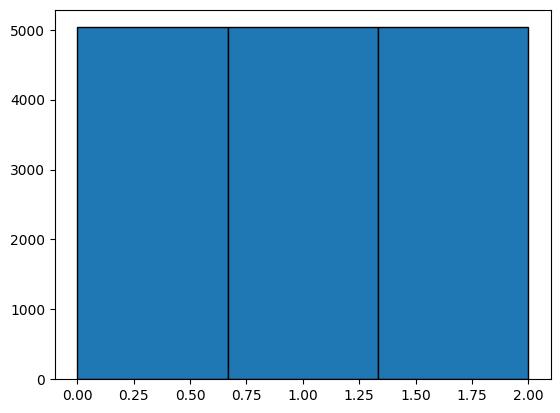

In [3494]:
plt.hist(y_train, bins=3, edgecolor='black')

In [3495]:
%%time

param_grid = {
    'max_depth': [8],
    'learning_rate': [0.1],
    'n_estimators': [350],
    'subsample': [0.8],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')

# Thiết lập GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Tối ưu hóa dựa trên accuracy
    n_jobs=3, 
    verbose=1
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# In tham số tốt nhất và điểm số
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 350, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.5036742800397219
CPU times: total: 47.4 s
Wall time: 25.1 s


In [3496]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.3819

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.26      0.24       508
           1       0.54      0.47      0.50      1206
           2       0.27      0.31      0.29       598

    accuracy                           0.38      2312
   macro avg       0.35      0.35      0.35      2312
weighted avg       0.40      0.38      0.39      2312


Confusion Matrix:
[[132 222 154]
 [292 563 351]
 [153 257 188]]


In [3497]:
le.transform(['Up', 'Down', 'Neutral'])

array([2, 0, 1])

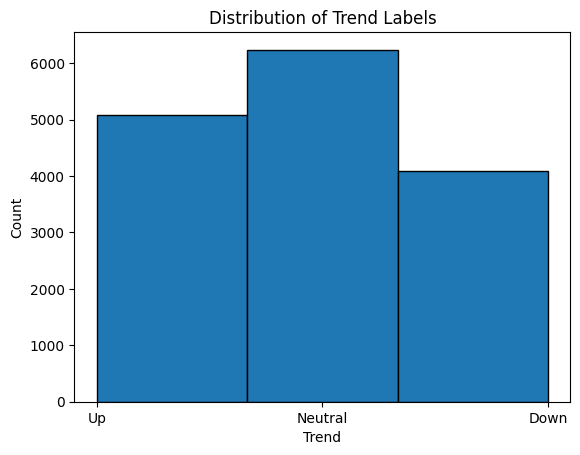

In [3498]:
plt.hist(df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

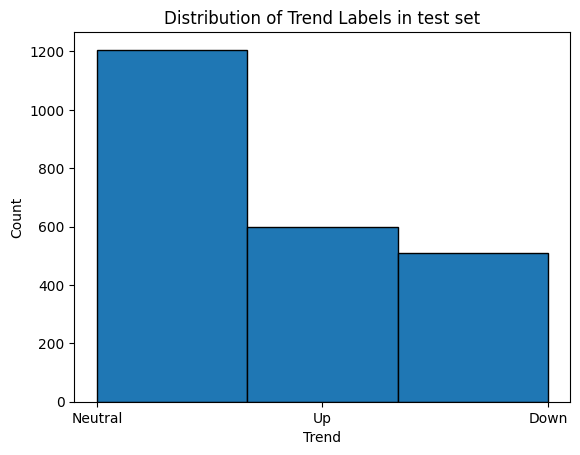

In [3499]:
plt.hist(test_df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels in test set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

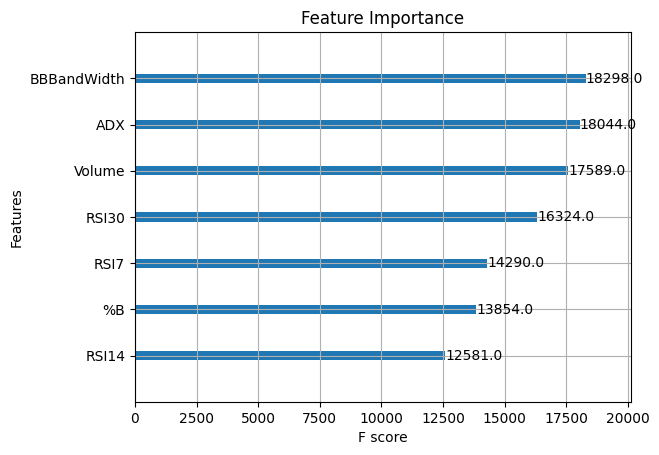

In [3500]:
xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.show()